In [ ]:
import os
import pickle
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
import torch

def load_pkl_files(folder_path='.'):
    """
    Load all pkl files matching the pattern in the specified folder.
    Returns a dictionary with file parameters and results.
    """
    pkl_files = []
    pattern = r'results_D=(\d+)_Q=(\d+)_M=(\d+)_K=(\d+)_N=(\d+)_noise_var=([0-9.]+)\.pkl'
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.pkl'):
            match = re.match(pattern, filename)
            if match:
                D, Q, M, K, N, noise_var = match.groups()
                pkl_files.append({
                    'filename': filename,
                    'D': int(D),
                    'Q': int(Q),
                    'M': int(M),
                    'K': int(K),
                    'N': int(N),
                    'noise_var': float(noise_var)
                })
    
    return pkl_files

def extract_metrics_from_results(results_data):
    """
    Extract RMSE and CRPS metrics from the results dictionary.
    Returns a list of metric dictionaries.
    """
    metrics_list = []
    
    for run_key, run_data in results_data.items():
        for method_name, method_results in run_data.items():
            # Extract base method name (remove iteration suffix)
            base_method = method_name.split('_')[0]
            
            # Handle different result formats
            if isinstance(method_results, (list, tuple)) and len(method_results) >= 2:
                rmse = method_results[0]
                crps = method_results[1]
            else:
                continue
                
            # Convert torch tensors to float values
            rmse_val = rmse.detach().cpu().item() if isinstance(rmse, torch.Tensor) else float(rmse)
            crps_val = crps.detach().cpu().item() if isinstance(crps, torch.Tensor) else float(crps)
            
            metrics_list.append({
                'run': run_key,
                'method': base_method,
                'rmse': rmse_val,
                'crps': crps_val
            })
    
    return metrics_list

def organize_data_by_parameters(pkl_files):
    """
    Load all pkl files and organize data by parameters.
    Returns a structured dictionary with all metrics.
    """
    all_data = []
    
    for file_info in pkl_files:
        filepath = file_info['filename']
        try:
            with open(filepath, 'rb') as f:
                results_data = pickle.load(f)
            
            metrics_list = extract_metrics_from_results(results_data)
            
            for metric in metrics_list:
                metric.update({
                    'D': file_info['D'],
                    'Q': file_info['Q'],
                    'M': file_info['M'],
                    'K': file_info['K'],
                    'N': file_info['N'],
                    'noise_var': file_info['noise_var']
                })
                all_data.append(metric)
                
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
    
    return all_data

def create_boxplot_fixed_d(data, metric_name='rmse', output_dir='plots'):
    """
    Create boxplots with fixed D values.
    Each subplot corresponds to one N value, with different Q values as separate boxplots.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    df = pd.DataFrame(data)
    
    # Get unique values for each parameter
    unique_d = sorted(df['D'].unique())
    unique_n = sorted(df['N'].unique())
    unique_q = sorted(df['Q'].unique())
    
    # Create plots for each D value
    for d_val in unique_d:
        df_d = df[df['D'] == d_val]
        
        if df_d.empty:
            continue
            
        # Create subplots for each N value
        fig, axes = plt.subplots(1, len(unique_n), figsize=(5*len(unique_n), 6))
        if len(unique_n) == 1:
            axes = [axes]
        
        fig.suptitle(f'{metric_name.upper()} Comparison (D={d_val})', fontsize=16)
        
        for i, n_val in enumerate(unique_n):
            ax = axes[i]
            df_dn = df_d[df_d['N'] == n_val]
            
            if df_dn.empty:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'N={n_val}')
                continue
            
            # Prepare data for boxplot
            boxplot_data = []
            labels = []
            
            for q_val in unique_q:
                df_dnq = df_dn[df_dn['Q'] == q_val]
                if not df_dnq.empty:
                    boxplot_data.append(df_dnq[metric_name].values)
                    labels.append(f'Q={q_val}')
            
            if boxplot_data:
                bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
                
                # Color the boxes
                colors = plt.cm.Set3(np.linspace(0, 1, len(boxplot_data)))
                for patch, color in zip(bp['boxes'], colors):
                    patch.set_facecolor(color)
                    patch.set_alpha(0.7)
            
            ax.set_title(f'N={n_val}')
            ax.set_ylabel(metric_name.upper())
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'{metric_name}_boxplot_D{d_val}.png'), 
                   dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved boxplot for D={d_val}")

def create_boxplot_fixed_q(data, metric_name='rmse', output_dir='plots'):
    """
    Create boxplots with fixed Q values.
    Each subplot corresponds to one N value, with different D values as separate boxplots.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    df = pd.DataFrame(data)
    
    # Get unique values for each parameter
    unique_d = sorted(df['D'].unique())
    unique_n = sorted(df['N'].unique())
    unique_q = sorted(df['Q'].unique())
    
    # Create plots for each Q value
    for q_val in unique_q:
        df_q = df[df['Q'] == q_val]
        
        if df_q.empty:
            continue
            
        # Create subplots for each N value
        fig, axes = plt.subplots(1, len(unique_n), figsize=(5*len(unique_n), 6))
        if len(unique_n) == 1:
            axes = [axes]
        
        fig.suptitle(f'{metric_name.upper()} Comparison (K={q_val})', fontsize=16)
        
        for i, n_val in enumerate(unique_n):
            ax = axes[i]
            df_qn = df_q[df_q['N'] == n_val]
            
            if df_qn.empty:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'N={n_val}')
                continue
            
            # Prepare data for boxplot
            boxplot_data = []
            labels = []
            
            for d_val in unique_d:
                df_qnd = df_qn[df_qn['D'] == d_val]
                if not df_qnd.empty:
                    boxplot_data.append(df_qnd[metric_name].values)
                    labels.append(f'D={d_val}')
            
            if boxplot_data:
                bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
                
                # Color the boxes
                colors = plt.cm.Set2(np.linspace(0, 1, len(boxplot_data)))
                for patch, color in zip(bp['boxes'], colors):
                    patch.set_facecolor(color)
                    patch.set_alpha(0.7)
            
            ax.set_title(f'N={n_val}')
            ax.set_ylabel(metric_name.upper())
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'{metric_name}_boxplot_Q{q_val}.png'), 
                   dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved boxplot for Q={q_val}")

def create_method_comparison_boxplot(data, metric_name='rmse', output_dir='plots'):
    """
    Create boxplots comparing different methods across all parameter combinations.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    df = pd.DataFrame(data)
    
    # Get unique methods
    unique_methods = sorted(df['method'].unique())
    
    # Create overall method comparison
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    boxplot_data = []
    labels = []
    
    for method in unique_methods:
        method_data = df[df['method'] == method][metric_name].values
        if len(method_data) > 0:
            boxplot_data.append(method_data)
            labels.append(method)
    
    if boxplot_data:
        bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
        
        # Color the boxes
        colors = plt.cm.tab10(np.linspace(0, 1, len(boxplot_data)))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
    
    ax.set_title(f'{metric_name.upper()} Comparison Across All Methods', fontsize=14)
    ax.set_ylabel(metric_name.upper())
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{metric_name}_methods_comparison.png'), 
               dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved method comparison plot for {metric_name}")

def main():
    """
    Main function to load data and create all plots.
    """
    print("Loading pkl files...")
    pkl_files = load_pkl_files()
    
    if not pkl_files:
        print("No pkl files found matching the pattern!")
        return
    
    print(f"Found {len(pkl_files)} pkl files")
    
    print("Organizing data...")
    all_data = organize_data_by_parameters(pkl_files)
    
    if not all_data:
        print("No data extracted from pkl files!")
        return
    
    print(f"Extracted {len(all_data)} data points")
    
    # Create output directory
    output_dir = 'analysis_plots'
    
    # Create boxplots for both metrics
    for metric in ['rmse', 'crps']:
        print(f"\nCreating {metric} boxplots...")
        
        # Fixed D plots
        create_boxplot_fixed_d(all_data, metric, output_dir)
        
        # Fixed Q plots
        create_boxplot_fixed_q(all_data, metric, output_dir)
        
        # Method comparison plots
        create_method_comparison_boxplot(all_data, metric, output_dir)
    
    print(f"\nAll plots saved to '{output_dir}' directory")
    
    # Print summary statistics
    df = pd.DataFrame(all_data)
    print("\nSummary Statistics:")
    print(f"Unique D values: {sorted(df['D'].unique())}")
    print(f"Unique Q values: {sorted(df['Q'].unique())}")
    print(f"Unique N values: {sorted(df['N'].unique())}")
    print(f"Unique methods: {sorted(df['method'].unique())}")
    print(f"Total data points: {len(df)}")

if __name__ == "__main__":
    main()

In [36]:
import os
import pickle
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
import torch

In [55]:
def load_pkl_files(folder_path='.'):
    """
    Load all pkl files matching the pattern in the specified folder.
    Returns a dictionary with file parameters and results.
    """
    pkl_files = []
    pattern = r'results_D=(\d+)_Q=(\d+)_M=(\d+)_K=(\d+)_N=(\d+)_noise_var=([0-9.]+)\.pkl'
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.pkl'):
            match = re.match(pattern, filename)
            if match:
                D, Q, M, K, N, noise_var = match.groups()
                pkl_files.append({
                    'filename': filename,
                    'D': int(D),
                    'Q': int(Q),
                    'M': int(M),
                    'K': int(K),
                    'N': int(N),
                    'noise_var': float(noise_var)
                })
    
    return pkl_files

def extract_metrics_from_results(results_data):
    """
    Extract RMSE and CRPS metrics from the results dictionary.
    Returns a list of metric dictionaries.
    """
    metrics_list = []
    
    for run_key, run_data in results_data.items():
        for method_name, method_results in run_data.items():
            # Extract base method name (remove iteration suffix)
            base_method = method_name.split('_')[0]
            
            # Handle different result formats
            if isinstance(method_results, (list, tuple)) and len(method_results) >= 2:
                rmse = method_results[0]
                crps = method_results[1]
            else:
                continue
                
            # Convert torch tensors to float values
            rmse_val = rmse.detach().cpu().item() if isinstance(rmse, torch.Tensor) else float(rmse)
            crps_val = crps.detach().cpu().item() if isinstance(crps, torch.Tensor) else float(crps)
            
            metrics_list.append({
                'run': run_key,
                'method': base_method,
                'rmse': rmse_val,
                'crps': crps_val
            })
    
    return metrics_list

def organize_data_by_parameters(pkl_files, folder_path=''):
    """
    Load all pkl files and organize data by parameters.
    Returns a structured dictionary with all metrics.
    """
    all_data = []
    
    for file_info in pkl_files:
        filepath = file_info['filename']
        try:
            with open(os.path.join(folder_path, filepath), 'rb') as f:
                results_data = pickle.load(f)
            
            metrics_list = extract_metrics_from_results(results_data)
            
            for metric in metrics_list:
                metric.update({
                    'D': file_info['D'],
                    'Q': file_info['Q'],
                    'M': file_info['M'],
                    'K': file_info['K'],
                    'N': file_info['N'],
                    'noise_var': file_info['noise_var']
                })
                all_data.append(metric)
                
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
    
    return all_data

def create_boxplot_fixed_d(data, metric_name='rmse', output_dir='plots'):
    """
    Create boxplots with fixed D values.
    Each subplot corresponds to one N value, with different Q values as separate boxplots.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    df = pd.DataFrame(data)
    
    # Get unique values for each parameter
    unique_d = sorted(df['D'].unique())
    unique_n = sorted(df['N'].unique())
    unique_q = sorted(df['Q'].unique())
    
    # Create plots for each D value
    for d_val in unique_d:
        df_d = df[df['D'] == d_val]
        
        if df_d.empty:
            continue
            
        # Create subplots for each N value
        fig, axes = plt.subplots(1, len(unique_n), figsize=(5*len(unique_n), 6))
        if len(unique_n) == 1:
            axes = [axes]
        
        fig.suptitle(f'{metric_name.upper()} Comparison (D={d_val})', fontsize=16)
        
        for i, n_val in enumerate(unique_n):
            ax = axes[i]
            df_dn = df_d[df_d['N'] == n_val]
            
            if df_dn.empty:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'N={n_val}')
                continue
            
            # Prepare data for boxplot
            boxplot_data = []
            labels = []
            
            for q_val in unique_q:
                df_dnq = df_dn[df_dn['Q'] == q_val]
                if not df_dnq.empty:
                    boxplot_data.append(df_dnq[metric_name].values)
                    labels.append(f'K={q_val}')
            
            if boxplot_data:
                bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
                
                # Color the boxes
                colors = plt.cm.Set3(np.linspace(0, 1, len(boxplot_data)))
                for patch, color in zip(bp['boxes'], colors):
                    patch.set_facecolor(color)
                    patch.set_alpha(0.7)
            
            ax.set_title(f'N={n_val}')
            ax.set_ylabel(metric_name.upper())
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'{metric_name}_boxplot_D{d_val}.png'), 
                   dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved boxplot for D={d_val}")

def create_boxplot_fixed_q(data, metric_name='rmse', output_dir='plots'):
    """
    Create boxplots with fixed Q values.
    Each subplot corresponds to one N value, with different D values as separate boxplots.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    df = pd.DataFrame(data)
    
    # Get unique values for each parameter
    unique_d = sorted(df['D'].unique())
    unique_n = sorted(df['N'].unique())
    unique_q = sorted(df['Q'].unique())
    
    # Create plots for each Q value
    for q_val in unique_q:
        df_q = df[df['Q'] == q_val]
        
        if df_q.empty:
            continue
            
        # Create subplots for each N value
        fig, axes = plt.subplots(1, len(unique_n), figsize=(5*len(unique_n), 6))
        if len(unique_n) == 1:
            axes = [axes]
        
        fig.suptitle(f'{metric_name.upper()} Comparison (K={q_val})', fontsize=16)
        
        for i, n_val in enumerate(unique_n):
            ax = axes[i]
            df_qn = df_q[df_q['N'] == n_val]
            
            if df_qn.empty:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'N={n_val}')
                continue
            
            # Prepare data for boxplot
            boxplot_data = []
            labels = []
            
            for d_val in unique_d:
                df_qnd = df_qn[df_qn['D'] == d_val]
                if not df_qnd.empty:
                    boxplot_data.append(df_qnd[metric_name].values)
                    labels.append(f'D={d_val}')
            
            if boxplot_data:
                bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
                
                # Color the boxes
                colors = plt.cm.Set2(np.linspace(0, 1, len(boxplot_data)))
                for patch, color in zip(bp['boxes'], colors):
                    patch.set_facecolor(color)
                    patch.set_alpha(0.7)
            
            ax.set_title(f'N={n_val}')
            ax.set_ylabel(metric_name.upper())
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'{metric_name}_boxplot_K{q_val}.png'), 
                   dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved boxplot for K={q_val}")

def create_method_comparison_boxplot(data, metric_name='rmse', output_dir='plots'):
    """
    Create boxplots comparing different methods across all parameter combinations.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    df = pd.DataFrame(data)
    
    # Get unique methods
    unique_methods = sorted(df['method'].unique())
    
    # Create overall method comparison
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    boxplot_data = []
    labels = []
    
    for method in unique_methods:
        method_data = df[df['method'] == method][metric_name].values
        if len(method_data) > 0:
            boxplot_data.append(method_data)
            labels.append(method)
    
    if boxplot_data:
        bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
        
        # Color the boxes
        colors = plt.cm.tab10(np.linspace(0, 1, len(boxplot_data)))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
    
    ax.set_title(f'{metric_name.upper()} Comparison Across All Methods', fontsize=14)
    ax.set_ylabel(metric_name.upper())
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{metric_name}_methods_comparison.png'), 
               dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved method comparison plot for {metric_name}")

def create_boxplot_fixed_q(data, metric_name='rmse', output_dir='plots'):
    """
    Create boxplots with fixed Q values.
    Each subplot corresponds to one N value, with different D values as separate boxplots.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    df = pd.DataFrame(data)
    
    # Get unique values for each parameter
    unique_d = sorted(df['D'].unique())
    unique_n = sorted(df['N'].unique())
    unique_q = sorted(df['Q'].unique())
    
    # Create plots for each Q value
    for q_val in unique_q:
        df_q = df[df['Q'] == q_val]
        
        if df_q.empty:
            continue
            
        # Create subplots for each N value
        fig, axes = plt.subplots(1, len(unique_n), figsize=(5*len(unique_n), 6))
        if len(unique_n) == 1:
            axes = [axes]
        
        fig.suptitle(f'{metric_name.upper()} Comparison (K={q_val})', fontsize=16)
        
        for i, n_val in enumerate(unique_n):
            ax = axes[i]
            df_qn = df_q[df_q['N'] == n_val]
            
            if df_qn.empty:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'N={n_val}')
                continue
            
            # Prepare data for boxplot
            boxplot_data = []
            labels = []
            
            for d_val in unique_d:
                df_qnd = df_qn[df_qn['D'] == d_val]
                if not df_qnd.empty:
                    boxplot_data.append(df_qnd[metric_name].values)
                    labels.append(f'D={d_val}')
            
            if boxplot_data:
                bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
                
                # Color the boxes
                colors = plt.cm.Set2(np.linspace(0, 1, len(boxplot_data)))
                for patch, color in zip(bp['boxes'], colors):
                    patch.set_facecolor(color)
                    patch.set_alpha(0.7)
            
            ax.set_title(f'N={n_val}')
            ax.set_ylabel(metric_name.upper())
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'{metric_name}_boxplot_K{q_val}.png'), 
                   dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved boxplot for K={q_val}")

def create_boxplot_fixed_d_by_q(data, metric_name='rmse', output_dir='plots'):
    """
    Create boxplots with fixed D values.
    Each subplot corresponds to one Q value, with different N values as separate boxplots.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    df = pd.DataFrame(data)
    
    # Get unique values for each parameter
    unique_d = sorted(df['D'].unique())
    unique_n = sorted(df['N'].unique())
    unique_q = sorted(df['Q'].unique())
    
    # Create plots for each D value
    for d_val in unique_d:
        df_d = df[df['D'] == d_val]
        
        if df_d.empty:
            continue
            
        # Create subplots for each Q value
        fig, axes = plt.subplots(1, len(unique_q), figsize=(5*len(unique_q), 6))
        if len(unique_q) == 1:
            axes = [axes]
        
        fig.suptitle(f'{metric_name.upper()} Comparison (D={d_val})', fontsize=16)
        
        for i, q_val in enumerate(unique_q):
            ax = axes[i]
            df_dq = df_d[df_d['Q'] == q_val]
            
            if df_dq.empty:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'K={q_val}')
                continue
            
            # Prepare data for boxplot
            boxplot_data = []
            labels = []
            
            for n_val in unique_n:
                df_dqn = df_dq[df_dq['N'] == n_val]
                if not df_dqn.empty:
                    boxplot_data.append(df_dqn[metric_name].values)
                    labels.append(f'N={n_val}')
            
            if boxplot_data:
                bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
                
                # Color the boxes
                colors = plt.cm.Set1(np.linspace(0, 1, len(boxplot_data)))
                for patch, color in zip(bp['boxes'], colors):
                    patch.set_facecolor(color)
                    patch.set_alpha(0.7)
            
            ax.set_title(f'K={q_val}')
            ax.set_ylabel(metric_name.upper())
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'{metric_name}_boxplot_D{d_val}_by_K.png'), 
                   dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved boxplot for D={d_val} by K values")

In [96]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def remove_outliers_iqr(values):
    """Remove outliers using IQR method."""
    q1 = np.percentile(values, 25)
    q3 = np.percentile(values, 75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return [v for v in values if lower <= v <= upper]


def create_uniform_boxplot(data, metric_name='rmse', group_by='D', output_dir='plots'):
    """
    Create unified boxplot format with mean overlay excluding outliers,
    grouped by D, Q, or N depending on the use case.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    df = pd.DataFrame(data)
    other_keys = {'D', 'K', 'N'} - {group_by}
    fixed_key1, fixed_key2 = sorted(list(other_keys))

    unique_group_vals = sorted(df[group_by].unique())
    unique_fixed1 = sorted(df[fixed_key1].unique())
    unique_fixed2 = sorted(df[fixed_key2].unique())

    for f1 in unique_fixed1:
        for f2 in unique_fixed2:
            df_sub = df[(df[fixed_key1] == f1) & (df[fixed_key2] == f2)]
            if df_sub.empty:
                continue

            boxplot_data = []
            labels = []
            means = []

            for gv in unique_group_vals:
                vals = df_sub[df_sub[group_by] == gv][metric_name].values
                if len(vals) > 0:
                    filtered_vals = remove_outliers_iqr(vals)
                    boxplot_data.append(vals)
                    labels.append(f'{group_by}={gv}')
                    means.append(np.mean(filtered_vals) if filtered_vals else np.nan)

            fig, ax = plt.subplots(figsize=(10, 6))
            # bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True, showfliers=False)

            # for patch in bp['boxes']:
            #     patch.set_facecolor('gray')
            #     patch.set_edgecolor('black')

            # ax.plot(
            #     range(1, len(labels) + 1),
            #     means,
            #     marker='o',
            #     color='black',
            #     linestyle='--',
            #     label='Mean (no outliers)'
            # )

            # ax.set_title(f'{metric_name.upper()} vs {group_by} (Fixed {fixed_key1}={f1}, {fixed_key2}={f2})')
            # ax.set_ylabel(metric_name.upper())
            # ax.grid(True, axis='y')
            # ax.tick_params(axis='x', rotation=45)
            # ax.legend()

            plt.rcParams.update({
                'font.size': 14,
                'axes.titlesize': 18,
                'axes.labelsize': 16,
                'xtick.labelsize': 14,
                'ytick.labelsize': 14,
                'legend.fontsize': 14
            })

            bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True, showfliers=False)

            for patch in bp['boxes']:
                patch.set_facecolor('gray')
                patch.set_edgecolor('black')

            ax.plot(
                range(1, len(labels) + 1),
                means,
                marker='o',
                color='black',
                linestyle='--',
                label='Mean'
            )

            ax.set_title(f'{metric_name.upper()} vs {group_by} (Fixed {fixed_key1}={f1}, {fixed_key2}={f2})', fontsize=18)
            ax.set_ylabel(metric_name.upper(), fontsize=16)
            ax.grid(True, axis='y')
            ax.tick_params(axis='x', rotation=45, labelsize=14)
            ax.legend(fontsize=14)

            fname = f'{metric_name}_boxplot_{group_by}_fixed_{fixed_key1}{f1}_{fixed_key2}{f2}.png'
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, fname), dpi=300, bbox_inches='tight')
            plt.close()
            print(f"Saved {metric_name.upper()} boxplot to {fname}")


In [86]:
pkl_files = load_pkl_files('exp_data/erosion/')
all_data = organize_data_by_parameters(pkl_files, 'exp_data/erosion/')
create_uniform_boxplot(all_data, metric_name='rmse', group_by='D', output_dir='plots')

C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\2906578242.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True, showfliers=False)


Saved RMSE boxplot to rmse_boxplot_D_fixed_N1000_Q3.png


C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\2906578242.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True, showfliers=False)


Saved RMSE boxplot to rmse_boxplot_D_fixed_N1000_Q5.png


C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\2906578242.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True, showfliers=False)


Saved RMSE boxplot to rmse_boxplot_D_fixed_N1000_Q7.png


C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\2906578242.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True, showfliers=False)


Saved RMSE boxplot to rmse_boxplot_D_fixed_N3000_Q3.png


C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\2906578242.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True, showfliers=False)


Saved RMSE boxplot to rmse_boxplot_D_fixed_N3000_Q5.png


C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\2906578242.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True, showfliers=False)


Saved RMSE boxplot to rmse_boxplot_D_fixed_N3000_Q7.png


C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\2906578242.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True, showfliers=False)


Saved RMSE boxplot to rmse_boxplot_D_fixed_N5000_Q3.png


C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\2906578242.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True, showfliers=False)


Saved RMSE boxplot to rmse_boxplot_D_fixed_N5000_Q5.png


C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\2906578242.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True, showfliers=False)


Saved RMSE boxplot to rmse_boxplot_D_fixed_N5000_Q7.png


In [90]:
def rename_q_to_k_and_remove_k(data):
    """
    对嵌套字典数据中的每个元素：
    - 删除原有 'K' 键
    - 将 'Q' 重命名为 'K'
    返回修改后的新数据结构。
    """
    new_data = []

    for item in data:
        if 'K' in item:
            del item['K']
        if 'Q' in item:
            item['K'] = item.pop('Q')
        new_data.append(item)

    return new_data

all_data_mod = rename_q_to_k_and_remove_k(all_data)

In [99]:
create_uniform_boxplot(all_data_mod, metric_name='rmse', group_by='N', output_dir='plots')

C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\755009027.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True, showfliers=False)


Saved RMSE boxplot to rmse_boxplot_N_fixed_D20_K3.png


C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\755009027.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True, showfliers=False)


Saved RMSE boxplot to rmse_boxplot_N_fixed_D20_K5.png


C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\755009027.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True, showfliers=False)


Saved RMSE boxplot to rmse_boxplot_N_fixed_D20_K7.png


C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\755009027.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True, showfliers=False)


Saved RMSE boxplot to rmse_boxplot_N_fixed_D30_K3.png


C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\755009027.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True, showfliers=False)


Saved RMSE boxplot to rmse_boxplot_N_fixed_D30_K5.png


C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\755009027.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True, showfliers=False)


Saved RMSE boxplot to rmse_boxplot_N_fixed_D30_K7.png


C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\755009027.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True, showfliers=False)


Saved RMSE boxplot to rmse_boxplot_N_fixed_D50_K3.png


C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\755009027.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True, showfliers=False)


Saved RMSE boxplot to rmse_boxplot_N_fixed_D50_K5.png


C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\755009027.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True, showfliers=False)


Saved RMSE boxplot to rmse_boxplot_N_fixed_D50_K7.png


C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\755009027.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True, showfliers=False)


Saved RMSE boxplot to rmse_boxplot_N_fixed_D100_K3.png


C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\755009027.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True, showfliers=False)


Saved RMSE boxplot to rmse_boxplot_N_fixed_D100_K5.png


C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\755009027.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True, showfliers=False)


Saved RMSE boxplot to rmse_boxplot_N_fixed_D100_K7.png


In [56]:
pkl_files = load_pkl_files('exp_data/erosion/')
all_data = organize_data_by_parameters(pkl_files, 'exp_data/erosion/')

In [57]:
len(all_data)

350

In [58]:
metric = "rmse"
output_dir = 'exp_data/erosion/analysis_plots'
create_boxplot_fixed_d(all_data, metric, output_dir)

C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:138: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:138: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:138: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)


Saved boxplot for D=20


C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:138: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:138: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:138: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)


Saved boxplot for D=30


C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:138: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:138: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:138: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)


Saved boxplot for D=50


C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:138: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:138: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:138: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)


Saved boxplot for D=100


In [59]:
create_boxplot_fixed_q(all_data, metric, output_dir)

C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:318: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:318: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:318: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)


Saved boxplot for K=3


C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:318: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:318: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:318: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)


Saved boxplot for K=5


C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:318: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:318: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:318: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)


Saved boxplot for K=7


In [60]:
create_boxplot_fixed_d_by_q(all_data, metric, output_dir)

C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:386: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:386: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:386: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)


Saved boxplot for D=20 by K values


C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:386: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:386: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:386: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)


Saved boxplot for D=30 by K values


C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:386: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:386: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:386: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)


Saved boxplot for D=50 by K values


C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:386: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:386: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)
C:\Users\yxu59\AppData\Local\Temp\ipykernel_35076\1023783599.py:386: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)


Saved boxplot for D=100 by K values


In [31]:
import torch
import gpytorch
from matplotlib import pyplot as plt

# 模拟数据
train_x = torch.linspace(0, 10, 100).unsqueeze(-1)
train_y = torch.sin(train_x) + 0.3 * torch.randn(train_x.size())

from gpytorch.kernels import Kernel
from gpytorch.constraints import Positive
from gpytorch.lazy import NonLazyTensor
import torch

class NonstationaryRBFKernel(Kernel):
    is_stationary = False

    def __init__(self, **kwargs):
        super().__init__(has_lengthscale=False, **kwargs)

        self.raw_outputscale = torch.nn.Parameter(torch.tensor(1.0))
        self.register_constraint("raw_outputscale", Positive())

        self.lengthscale_fn = torch.nn.Sequential(
            torch.nn.Linear(1, 10),
            torch.nn.Tanh(),
            torch.nn.Linear(10, 1),
            torch.nn.Softplus()
        )

    @property
    def outputscale(self):
        return self.raw_outputscale_constraint.transform(self.raw_outputscale)

    def forward(self, x1, x2, **params):
        if x1.ndim == 1:
            x1 = x1.unsqueeze(-1)
        if x2.ndim == 1:
            x2 = x2.unsqueeze(-1)

        l1 = self.lengthscale_fn(x1).squeeze(-1) + 1e-4
        l2 = self.lengthscale_fn(x2).squeeze(-1) + 1e-4

        dists = (x1 - x2.transpose(0, 1)).pow(2).squeeze(-1)
        ls_sum = l1[:, None] ** 2 + l2[None, :] ** 2

        kernel = self.outputscale * torch.exp(-dists / ls_sum)

        # ✅ Wrap as LazyTensor
        return NonLazyTensor(kernel)



ImportError: cannot import name 'NonLazyTensor' from 'gpytorch.lazy' (c:\Users\yxu59\AppData\Local\miniconda3\envs\jumpGP\Lib\site-packages\gpytorch\lazy\__init__.py)

In [32]:
class NonstationaryGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = NonstationaryRBFKernel()
    
    def forward(self, x):
        mean = self.mean_module(x)
        cov = self.covar_module(x, x)
        return gpytorch.distributions.MultivariateNormal(mean, cov)


In [ ]:
python DJGP_test_validation.py --folder_name "2025_07_17_13_07" --Q 3 --n 25 --num_steps 500

In [44]:
!python erosion_new_dataset.py

  File "c:\Users\yxu59\files\spring2025\park\code\DeepMahalaJumpGP\erosion_new_dataset.py", line 302
    batch_size = batch_size
    ^^^^^^^^^^^^^^^^^^^^^^^
SyntaxError: keyword argument repeated: batch_size


In [46]:
import pickle

# 打开文件（注意 rb 模式）
with open('results_D=30_Q=5_M=25_K=5_N=1000_noise_var=4_method=random projection.pkl', 'rb') as f:
    data = pickle.load(f)
# data 就是你之前 dump 的对象
data

{'1': {'JGP_sir': [5],
  'DeepGP_0': [662.56787109375, 654.4005126953125, 31.935194730758667],
  'DJGP_0': [tensor(345.7820, device='cuda:0'),
   tensor(99.9399, device='cuda:0'),
   219.39378690719604]},
 '2': {'JGP_sir': [5],
  'DeepGP_0': [689.3164672851562, 683.91552734375, 33.258631467819214],
  'DJGP_0': [tensor(617.2709, device='cuda:0'),
   tensor(261.8561, device='cuda:0'),
   222.10664916038513]},
 '3': {'JGP_sir': [5],
  'DeepGP_0': [767.5528564453125, 753.6787719726562, 32.484373569488525],
  'DJGP_0': [tensor(884.0201, device='cuda:0'),
   tensor(484.4942, device='cuda:0'),
   238.00284719467163]},
 '4': {'JGP_sir': [5],
  'DeepGP_0': [742.9010620117188, 732.2081298828125, 33.53593063354492],
  'DJGP_0': [tensor(800.1879, device='cuda:0'),
   tensor(406.3758, device='cuda:0'),
   238.74982500076294]},
 '5': {'JGP_sir': [5],
  'DeepGP_0': [744.2670288085938, 733.249755859375, 44.42010140419006],
  'DJGP_0': [tensor(755.8309, device='cuda:0'),
   tensor(360.9321, device='cud

In [32]:
import pickle

# 打开文件（注意 rb 模式）
with open('Appliances_m1n_erosion_res.pkl', 'rb') as f:
    m1n_data = pickle.load(f)
# data 就是你之前 dump 的对象
m1n_data

{0: [{'m1': 2,
   'm2': 40,
   'rmse': tensor(84.6640, device='cuda:0'),
   'mean_crps': tensor(30.7430, device='cuda:0'),
   'run_time': 406.61537981033325,
   'n': 15,
   'batch_size': 64},
  {'m1': 2,
   'm2': 40,
   'rmse': tensor(90.1553, device='cuda:0'),
   'mean_crps': tensor(32.9824, device='cuda:0'),
   'run_time': 499.4170410633087,
   'n': 25,
   'batch_size': 64},
  {'m1': 2,
   'm2': 40,
   'rmse': tensor(91.8614, device='cuda:0'),
   'mean_crps': tensor(33.8262, device='cuda:0'),
   'run_time': 568.9976556301117,
   'n': 35,
   'batch_size': 64},
  {'m1': 2,
   'm2': 40,
   'rmse': tensor(92.0570, device='cuda:0'),
   'mean_crps': tensor(34.4475, device='cuda:0'),
   'run_time': 641.6588242053986,
   'n': 45,
   'batch_size': 64},
  {'m1': 4,
   'm2': 40,
   'rmse': tensor(88.4946, device='cuda:0'),
   'mean_crps': tensor(31.3137, device='cuda:0'),
   'run_time': 449.82134103775024,
   'n': 15,
   'batch_size': 64},
  {'m1': 4,
   'm2': 40,
   'rmse': tensor(88.2266, dev

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def process_data(data):
    """
    处理数据，将其转换为DataFrame格式
    """
    all_results = []
    
    for seed, results_list in data.items():
        for result in results_list:
            # 处理每个结果字典
            processed_result = {}
            for key, value in result.items():
                if isinstance(value, torch.Tensor):
                    # 将torch.tensor转换为float
                    processed_result[key] = value.cpu().item()
                else:
                    processed_result[key] = value
            
            processed_result['seed'] = seed
            all_results.append(processed_result)
    
    df = pd.DataFrame(all_results)
    return df

def create_heatmaps(df, save_plots=True):
    """
    创建m1和n的RMSE和CRPS热力图
    """
    # 计算每个(m1, n)组合的平均值
    grouped = df.groupby(['m1', 'n']).agg({
        'rmse': ['mean', 'std', 'count'],
        'mean_crps': ['mean', 'std', 'count'],
        'run_time': 'mean'
    }).round(4)
    
    print("分组统计信息:")
    print(grouped)
    
    # 创建透视表用于热力图
    rmse_pivot = df.groupby(['m1', 'n'])['rmse'].mean().unstack()
    crps_pivot = df.groupby(['m1', 'n'])['mean_crps'].mean().unstack()
    
    # 创建热力图
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # 1. RMSE均值热力图
    sns.heatmap(rmse_pivot, annot=True, fmt='.4f', cmap='Reds', 
                ax=axes[0], cbar_kws={'label': 'RMSE'})
    axes[0].set_title('RMSE Heat Map (Average across seeds)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('n (Neighborhood Size)', fontsize=12)
    axes[0].set_ylabel('m1 (Local Inducing Points)', fontsize=12)
    
    # 2. CRPS均值热力图
    sns.heatmap(crps_pivot, annot=True, fmt='.4f', cmap='Blues', 
                ax=axes[1], cbar_kws={'label': 'CRPS'})
    axes[1].set_title('CRPS Heat Map (Average across seeds)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('n (Neighborhood Size)', fontsize=12)
    axes[1].set_ylabel('m1 (Local Inducing Points)', fontsize=12)
    
    # 3. RMSE标准差热力图
    # rmse_std_pivot = df.groupby(['m1', 'n'])['rmse'].std().unstack()
    # sns.heatmap(rmse_std_pivot, annot=True, fmt='.4f', cmap='Oranges', 
    #             ax=axes[1,0], cbar_kws={'label': 'RMSE Std'})
    # axes[1,0].set_title('RMSE Standard Deviation Heat Map', fontsize=14, fontweight='bold')
    # axes[1,0].set_xlabel('n (Neighborhood Size)', fontsize=12)
    # axes[1,0].set_ylabel('m1 (Local Inducing Points)', fontsize=12)
    
    # # 4. CRPS标准差热力图
    # crps_std_pivot = df.groupby(['m1', 'n'])['mean_crps'].std().unstack()
    # sns.heatmap(crps_std_pivot, annot=True, fmt='.4f', cmap='Purples', 
    #             ax=axes[1,1], cbar_kws={'label': 'CRPS Std'})
    # axes[1,1].set_title('CRPS Standard Deviation Heat Map', fontsize=14, fontweight='bold')
    # axes[1,1].set_xlabel('n (Neighborhood Size)', fontsize=12)
    # axes[1,1].set_ylabel('m1 (Local Inducing Points)', fontsize=12)
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig('m1_n_heatmaps.png', dpi=300, bbox_inches='tight')
        plt.savefig('m1_n_heatmaps.pdf', bbox_inches='tight')
        print("热力图已保存为 m1_n_heatmaps.png 和 m1_n_heatmaps.pdf")
    
    plt.show()
    
    return rmse_pivot, crps_pivot

def create_individual_heatmaps(df, save_plots=True):
    """
    创建单独的大尺寸热力图
    """
    # 计算透视表
    rmse_pivot = df.groupby(['m1', 'n'])['rmse'].mean().unstack()
    crps_pivot = df.groupby(['m1', 'n'])['mean_crps'].mean().unstack()
    
    # RMSE热力图
    plt.figure(figsize=(12, 8))
    sns.heatmap(rmse_pivot, annot=True, fmt='.4f', cmap='Reds', 
                cbar_kws={'label': 'RMSE'}, linewidths=0.5)
    plt.title('RMSE Heat Map: m1 vs n (Average across all seeds)', fontsize=16, fontweight='bold')
    plt.xlabel('n (Neighborhood Size)', fontsize=14)
    plt.ylabel('m1 (Local Inducing Points)', fontsize=14)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    
    if save_plots:
        plt.savefig('rmse_m1_n_heatmap.png', dpi=300, bbox_inches='tight')
        plt.savefig('rmse_m1_n_heatmap.pdf', bbox_inches='tight')
    
    plt.show()
    
    # CRPS热力图
    plt.figure(figsize=(12, 8))
    sns.heatmap(crps_pivot, annot=True, fmt='.4f', cmap='Blues', 
                cbar_kws={'label': 'CRPS'}, linewidths=0.5)
    plt.title('CRPS Heat Map: m1 vs n (Average across all seeds)', fontsize=16, fontweight='bold')
    plt.xlabel('n (Neighborhood Size)', fontsize=14)
    plt.ylabel('m1 (Local Inducing Points)', fontsize=14)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    
    if save_plots:
        plt.savefig('crps_m1_n_heatmap.png', dpi=300, bbox_inches='tight')
        plt.savefig('crps_m1_n_heatmap.pdf', bbox_inches='tight')
    
    plt.show()

def analyze_best_combinations(df, top_n=5):
    """
    分析最佳的(m1, n)组合
    """
    # 计算每个组合的统计信息
    stats = df.groupby(['m1', 'n']).agg({
        'rmse': ['mean', 'std', 'min', 'max'],
        'mean_crps': ['mean', 'std', 'min', 'max'],
        'run_time': ['mean', 'std']
    }).round(4)
    
    # 扁平化列名
    stats.columns = ['_'.join(col).strip() for col in stats.columns]
    stats = stats.reset_index()
    
    print("=== 最佳 (m1, n) 组合分析 ===")
    
    print(f"\n前 {top_n} 个最低平均RMSE组合:")
    best_rmse = stats.nsmallest(top_n, 'rmse_mean')
    print(best_rmse[['m1', 'n', 'rmse_mean', 'rmse_std', 'mean_crps_mean', 'run_time_mean']])
    
    print(f"\n前 {top_n} 个最低平均CRPS组合:")
    best_crps = stats.nsmallest(top_n, 'mean_crps_mean')
    print(best_crps[['m1', 'n', 'rmse_mean', 'rmse_std', 'mean_crps_mean', 'run_time_mean']])
    
    # 综合评分（RMSE和CRPS归一化后相加）
    stats['rmse_norm'] = (stats['rmse_mean'] - stats['rmse_mean'].min()) / (stats['rmse_mean'].max() - stats['rmse_mean'].min())
    stats['crps_norm'] = (stats['mean_crps_mean'] - stats['mean_crps_mean'].min()) / (stats['mean_crps_mean'].max() - stats['mean_crps_mean'].min())
    stats['combined_score'] = stats['rmse_norm'] + stats['crps_norm']
    
    print(f"\n前 {top_n} 个最佳综合评分组合:")
    best_combined = stats.nsmallest(top_n, 'combined_score')
    print(best_combined[['m1', 'n', 'rmse_mean', 'mean_crps_mean', 'run_time_mean', 'combined_score']])
    
    return stats

def main():
    """
    主函数
    """
    # 这里放入您的数据
    data = {0: [{'m1': 2, 'm2': 40, 'rmse': torch.tensor(4.4509), 'mean_crps': torch.tensor(1.6255), 'run_time': 536.69, 'n': 15, 'batch_size': 64},
                # ... 您的完整数据 ...
               ]}  # 请将您的完整数据粘贴到这里
    
    # 处理数据
    print("处理数据...")
    df = process_data(data)
    
    print(f"数据形状: {df.shape}")
    print(f"m1的取值: {sorted(df['m1'].unique())}")
    print(f"n的取值: {sorted(df['n'].unique())}")
    print(f"m2的取值: {sorted(df['m2'].unique())}")
    print(f"不同seed数量: {df['seed'].nunique()}")
    
    # 创建热力图
    print("\n创建热力图...")
    rmse_pivot, crps_pivot = create_heatmaps(df, save_plots=True)
    
    # 创建单独的热力图
    print("\n创建单独的热力图...")
    create_individual_heatmaps(df, save_plots=True)
    
    # 分析最佳组合
    print("\n分析最佳组合...")
    stats = analyze_best_combinations(df)
    
    # 输出总结
    print("\n=== 数据总结 ===")
    print(f"总实验次数: {len(df)}")
    print(f"不同(m1, n)组合数: {df.groupby(['m1', 'n']).ngroups}")
    print(f"RMSE范围: {df['rmse'].min():.4f} - {df['rmse'].max():.4f}")
    print(f"CRPS范围: {df['mean_crps'].min():.4f} - {df['mean_crps'].max():.4f}")
    print(f"运行时间范围: {df['run_time'].min():.1f} - {df['run_time'].max():.1f} 秒")

分组统计信息:
          rmse                mean_crps                run_time
          mean      std count      mean     std count      mean
m1 n                                                           
2  15  91.9632   9.8619    10   33.7750  2.8582    10  382.3984
   25  92.0665   9.7432    10   33.9144  2.8731    10  461.0175
   35  91.3022  10.4329    10   34.0428  3.0522    10  521.4713
   45  92.0849  10.3996    10   34.2392  2.7408    10  615.3799
4  15  91.3010  10.6140    10   33.4976  3.1761    10  386.8721
   25  90.8368  10.0573    10   33.6162  2.9583    10  459.0901
   35  92.1374   9.7180    10   34.1605  3.0237    10  520.8055
   45  91.5641  11.5067    10   33.8638  3.4644    10  612.3419
6  15  90.4197  10.3778    10   33.0888  2.8423    10  389.9063
   25  90.7839  10.3194    10   33.2926  2.9840    10  469.9920
   35  92.6290   9.9258    10   34.3913  2.9798    10  518.1428
   45  91.2444  10.6383    10   34.2587  3.4050    10  608.2565
热力图已保存为 m1_n_heatmaps.png 和 m1_n

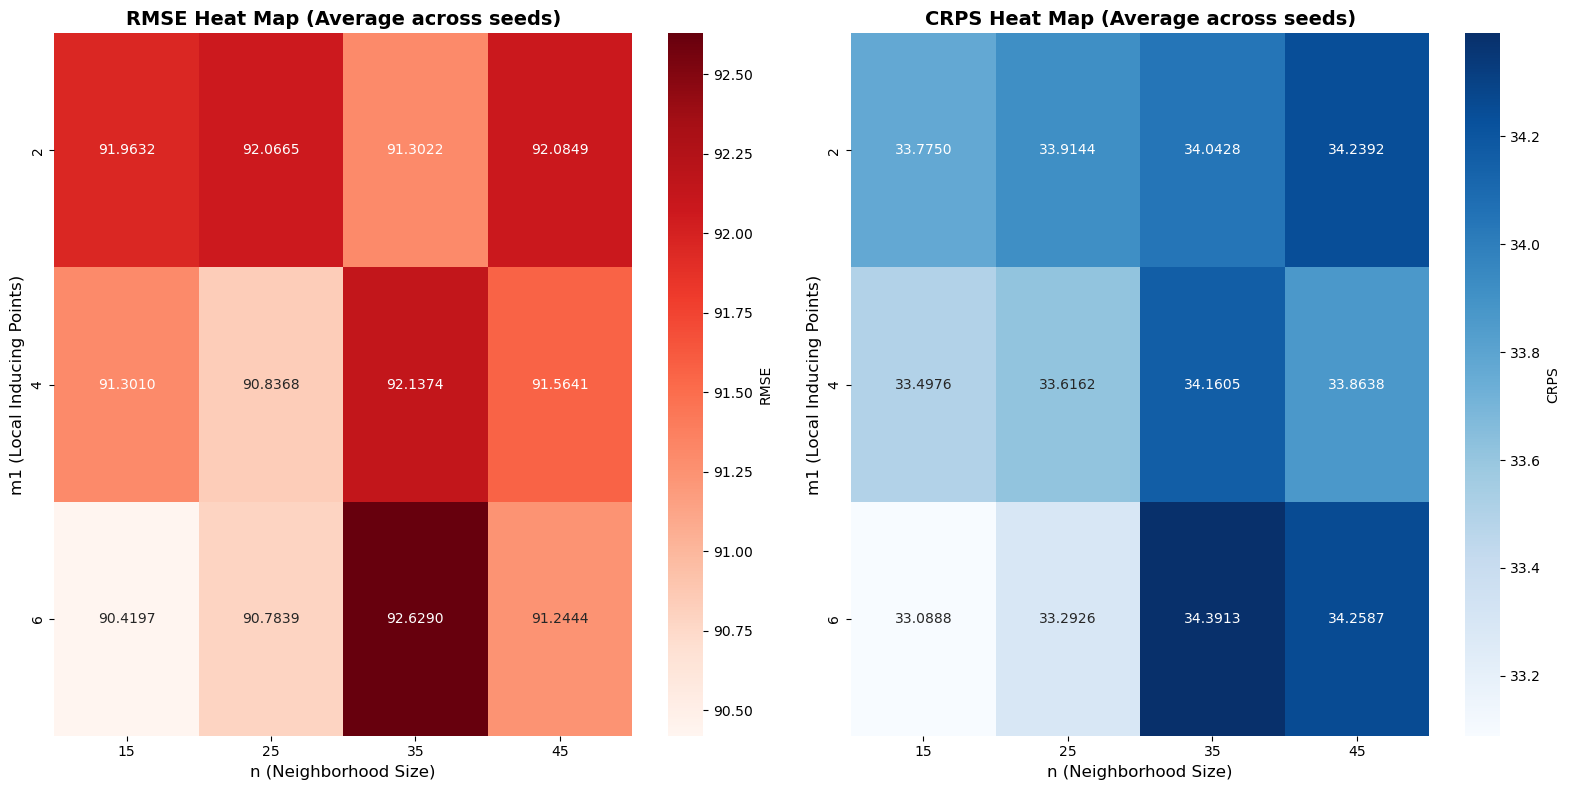

In [33]:
# 处理数据
df = process_data(m1n_data)

# 创建热力图
rmse_pivot, crps_pivot = create_heatmaps(df, save_plots=True)

# 创建单独的热力图
# create_individual_heatmaps(df, save_plots=True)

# 分析最佳组合
# stats = analyze_best_combinations(df)

In [28]:
import pickle

# 打开文件（注意 rb 模式）
# with open('minibatch_erosion_res.pkl', 'rb') as f:
with open('minibatch_total_res_Appliances.pkl', 'rb') as f:
    minibatch_data = pickle.load(f)
# data 就是你之前 dump 的对象
minibatch_data

{0: [{'m1': 2,
   'm2': 20,
   'rmse': tensor(84.8877, device='cuda:0'),
   'mean_crps': tensor(30.8682, device='cuda:0'),
   'run_time': 1827.9447371959686,
   'n': 20,
   'batch_size': 32},
  {'m1': 2,
   'm2': 20,
   'rmse': tensor(89.0051, device='cuda:0'),
   'mean_crps': tensor(32.4377, device='cuda:0'),
   'run_time': 1107.095752954483,
   'n': 20,
   'batch_size': 64},
  {'m1': 2,
   'm2': 20,
   'rmse': tensor(90.2880, device='cuda:0'),
   'mean_crps': tensor(33.0616, device='cuda:0'),
   'run_time': 720.4830901622772,
   'n': 20,
   'batch_size': 128},
  {'m1': 2,
   'm2': 20,
   'rmse': tensor(87.7931, device='cuda:0'),
   'mean_crps': tensor(33.0938, device='cuda:0'),
   'run_time': 559.6753799915314,
   'n': 20,
   'batch_size': 256}],
 1: [{'m1': 2,
   'm2': 20,
   'rmse': tensor(97.2611, device='cuda:0'),
   'mean_crps': tensor(36.5438, device='cuda:0'),
   'run_time': 1836.5216529369354,
   'n': 20,
   'batch_size': 32},
  {'m1': 2,
   'm2': 20,
   'rmse': tensor(101.09

处理数据...
数据形状: (20, 8)
batch_size的取值: [np.int64(32), np.int64(64), np.int64(128), np.int64(256)]
不同seed数量: 5

创建batch_size分析图...
按batch_size分组的统计信息:
   batch_size  rmse_mean  rmse_std  mean_crps_mean  mean_crps_std  \
0          32    92.6343    4.8977         34.0909         2.0769   
1          64    94.6735    5.7922         35.1460         2.6273   
2         128    92.9750    2.8024         34.5081         1.5676   
3         256    93.1332    4.4914         34.6977         1.9383   

   run_time_mean  run_time_std  
0      1666.0456      151.7439  
1      1018.1291       83.7108  
2       663.4423       52.9593  
3       520.9884       33.7603  
图表已保存为 batch_size_analysis.png 和 batch_size_analysis.pdf


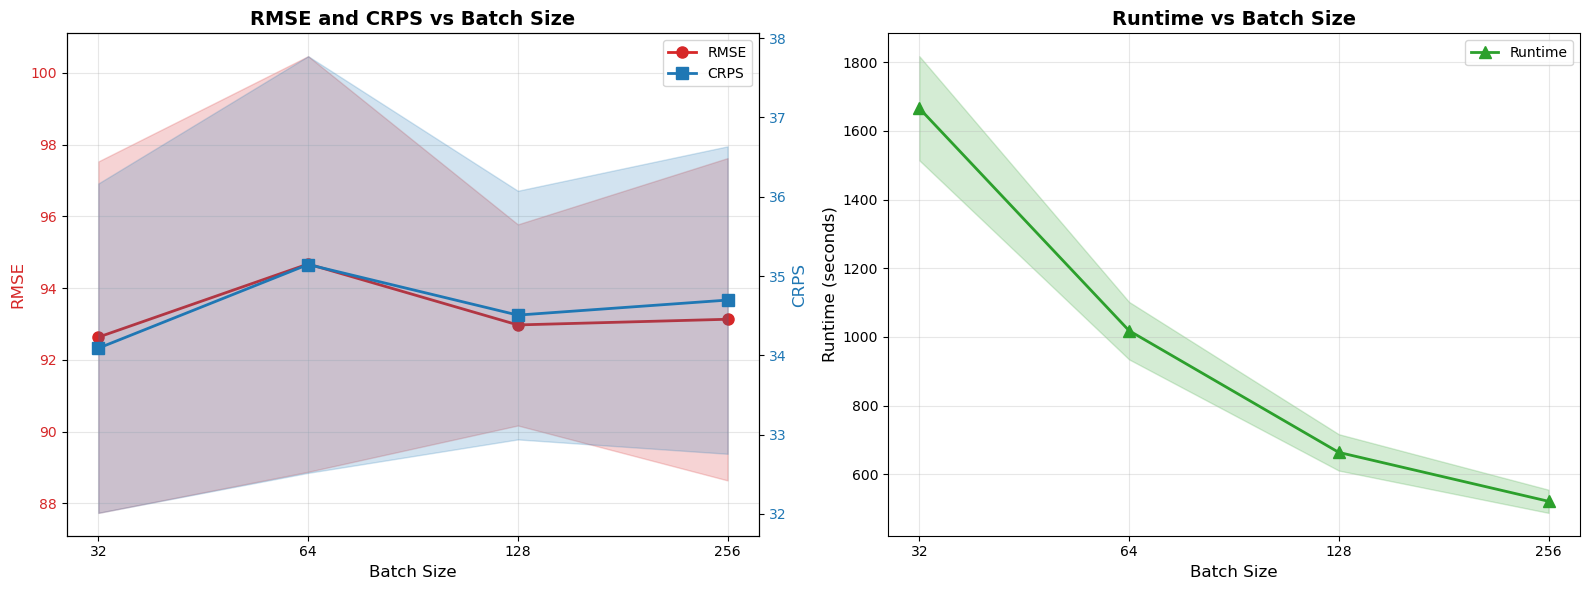


=== 详细统计分析 ===
               rmse                            mean_crps                   \
               mean     std      min       max      mean     std      min   
batch_size                                                                  
32          92.6343  4.8977  84.8877   97.2611   34.0909  2.0769  30.8682   
64          94.6735  5.7922  88.4523  101.0970   35.1460  2.6273  32.4377   
128         92.9750  2.8024  90.2880   96.9956   34.5081  1.5676  33.0616   
256         93.1332  4.4914  87.7931   99.9352   34.6977  1.9383  32.7550   

                      run_time                                  
                max       mean       std        min        max  
batch_size                                                      
32          36.5438  1666.0456  151.7439  1553.1014  1836.5217  
64          38.0574  1018.1291   83.7108   953.5735  1112.4551  
128         37.0006   663.4423   52.9593   620.1401   722.2509  
256         37.5956   520.9884   33.7603   495.0352   

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

def process_batch_data(data):
    """
    处理数据，将其转换为DataFrame格式
    """
    all_results = []
    
    for seed, results_list in data.items():
        for result in results_list:
            # 处理每个结果字典
            processed_result = {}
            for key, value in result.items():
                if isinstance(value, torch.Tensor):
                    # 将torch.tensor转换为float
                    processed_result[key] = value.cpu().item()
                else:
                    processed_result[key] = value
            
            processed_result['seed'] = seed
            all_results.append(processed_result)
    
    df = pd.DataFrame(all_results)
    return df

def create_batch_size_plots(df, save_plots=True):
    """
    创建关于batch_size的折线图
    """
    # 按batch_size分组计算均值和标准差
    grouped = df.groupby('batch_size').agg({
        'rmse': ['mean', 'std'],
        'mean_crps': ['mean', 'std'],
        'run_time': ['mean', 'std']
    }).round(4)
    
    # 重置索引并重命名列
    grouped.columns = ['_'.join(col).strip() for col in grouped.columns]
    grouped = grouped.reset_index()
    
    print("按batch_size分组的统计信息:")
    print(grouped)
    
    # 创建图形
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # === 第一个subplot: RMSE和CRPS的双y轴图 ===
    batch_sizes = grouped['batch_size']
    rmse_mean = grouped['rmse_mean']
    rmse_std = grouped['rmse_std']
    crps_mean = grouped['mean_crps_mean']
    crps_std = grouped['mean_crps_std']
    
    # 左y轴：RMSE
    color1 = 'tab:red'
    ax1.set_xlabel('Batch Size', fontsize=12)
    ax1.set_ylabel('RMSE', color=color1, fontsize=12)
    line1 = ax1.plot(batch_sizes, rmse_mean, color=color1, marker='o', 
                     linewidth=2, markersize=8, label='RMSE')
    ax1.fill_between(batch_sizes, rmse_mean - rmse_std, rmse_mean + rmse_std, 
                     color=color1, alpha=0.2)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, alpha=0.3)
    
    # 右y轴：CRPS
    ax1_twin = ax1.twinx()
    color2 = 'tab:blue'
    ax1_twin.set_ylabel('CRPS', color=color2, fontsize=12)
    line2 = ax1_twin.plot(batch_sizes, crps_mean, color=color2, marker='s', 
                          linewidth=2, markersize=8, label='CRPS')
    ax1_twin.fill_between(batch_sizes, crps_mean - crps_std, crps_mean + crps_std, 
                          color=color2, alpha=0.2)
    ax1_twin.tick_params(axis='y', labelcolor=color2)
    
    # 设置标题和图例
    ax1.set_title('RMSE and CRPS vs Batch Size', fontsize=14, fontweight='bold')
    ax1.set_xscale('log', base=2)  # 使用对数尺度显示batch_size
    ax1.set_xticks(batch_sizes)
    ax1.set_xticklabels([str(int(bs)) for bs in batch_sizes])
    
    # 合并图例
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_twin.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    # === 第二个subplot: Runtime ===
    runtime_mean = grouped['run_time_mean']
    runtime_std = grouped['run_time_std']
    
    color3 = 'tab:green'
    ax2.plot(batch_sizes, runtime_mean, color=color3, marker='^', 
             linewidth=2, markersize=8, label='Runtime')
    ax2.fill_between(batch_sizes, runtime_mean - runtime_std, runtime_mean + runtime_std, 
                     color=color3, alpha=0.2)
    
    ax2.set_xlabel('Batch Size', fontsize=12)
    ax2.set_ylabel('Runtime (seconds)', fontsize=12)
    ax2.set_title('Runtime vs Batch Size', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.set_xscale('log', base=2)  # 使用对数尺度显示batch_size
    ax2.set_xticks(batch_sizes)
    ax2.set_xticklabels([str(int(bs)) for bs in batch_sizes])
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig('batch_size_analysis.png', dpi=300, bbox_inches='tight')
        plt.savefig('batch_size_analysis.pdf', bbox_inches='tight')
        print("图表已保存为 batch_size_analysis.png 和 batch_size_analysis.pdf")
    
    plt.show()
    
    return grouped

def create_detailed_analysis(df):
    """
    创建详细的分析图表
    """
    # 计算统计信息
    stats = df.groupby('batch_size').agg({
        'rmse': ['mean', 'std', 'min', 'max'],
        'mean_crps': ['mean', 'std', 'min', 'max'],
        'run_time': ['mean', 'std', 'min', 'max']
    }).round(4)
    
    print("\n=== 详细统计分析 ===")
    print(stats)
    
    # 找出最佳batch_size
    batch_stats = df.groupby('batch_size').agg({
        'rmse': 'mean',
        'mean_crps': 'mean',
        'run_time': 'mean'
    })
    
    best_rmse_batch = batch_stats['rmse'].idxmin()
    best_crps_batch = batch_stats['mean_crps'].idxmin()
    fastest_batch = batch_stats['run_time'].idxmin()
    
    print(f"\n=== 最佳Batch Size分析 ===")
    print(f"最低RMSE的batch_size: {best_rmse_batch} (RMSE: {batch_stats.loc[best_rmse_batch, 'rmse']:.4f})")
    print(f"最低CRPS的batch_size: {best_crps_batch} (CRPS: {batch_stats.loc[best_crps_batch, 'mean_crps']:.4f})")
    print(f"最快运行的batch_size: {fastest_batch} (Runtime: {batch_stats.loc[fastest_batch, 'run_time']:.1f}s)")
    
    return batch_stats

def main():
    """
    主函数
    """
    # 您提供的数据
    data = minibatch_data
    
    # 处理数据
    print("处理数据...")
    df = process_batch_data(data)
    
    print(f"数据形状: {df.shape}")
    print(f"batch_size的取值: {sorted(df['batch_size'].unique())}")
    print(f"不同seed数量: {df['seed'].nunique()}")
    
    # 创建折线图
    print("\n创建batch_size分析图...")
    grouped = create_batch_size_plots(df, save_plots=True)
    
    # 详细分析
    batch_stats = create_detailed_analysis(df)
    
    return df, grouped, batch_stats

if __name__ == "__main__":
    df, grouped, batch_stats = main()

In [14]:
import pickle

# 方法1：基本读取
with open('total_res_finalversion.pkl', 'rb') as f:
    data = pickle.load(f)

data.keys()

dict_keys(['Wine Quality', 'Parkinsons Telemonitoring', 'Appliances Energy Prediction'])

In [16]:
data['Parkinsons Telemonitoring'][0].keys()

dict_keys(['jgp_sir', 'jgp_pca', 'jgp_raw', 'lmjgp', 'djgp'])

In [17]:
type(minibatch_data)

dict

In [30]:
full_batch_data = {}
for key in range(5):
    full_batch_data[key] = data['Appliances Energy Prediction'][key]['lmjgp']



In [26]:
full_batch_data

{0: [tensor(4.5293, device='cuda:0'),
  tensor(1.6500, device='cuda:0'),
  400.63923025131226],
 1: [tensor(4.3212, device='cuda:0'),
  tensor(1.6231, device='cuda:0'),
  385.31939721107483],
 2: [tensor(4.5038, device='cuda:0'),
  tensor(1.5892, device='cuda:0'),
  392.44168639183044],
 3: [tensor(4.0652, device='cuda:0'),
  tensor(1.4307, device='cuda:0'),
  394.1755299568176],
 4: [tensor(4.0961, device='cuda:0'),
  tensor(1.4760, device='cuda:0'),
  399.1601119041443]}

处理数据...
数据形状: (25, 8)
batch_size的取值: [np.int64(32), np.int64(64), np.int64(128), np.int64(256), np.int64(593)]
不同seed数量: 5

创建更新后的batch_size分析图...
按batch_size分组的统计信息:
   batch_size  rmse_mean  rmse_std  mean_crps_mean  mean_crps_std  \
0          32    92.6343    4.8977         34.0909         2.0769   
1          64    94.6735    5.7922         35.1460         2.6273   
2         128    92.9750    2.8024         34.5081         1.5676   
3         256    93.1332    4.4914         34.6977         1.9383   
4         593    92.7816    4.6796         34.1461         1.9441   

   run_time_mean  run_time_std  
0      1666.0456      151.7439  
1      1018.1291       83.7108  
2       663.4423       52.9593  
3       520.9884       33.7603  
4       367.0368        3.4643  
图表已保存为 batch_size_analysis_updated.png 和 batch_size_analysis_updated.pdf


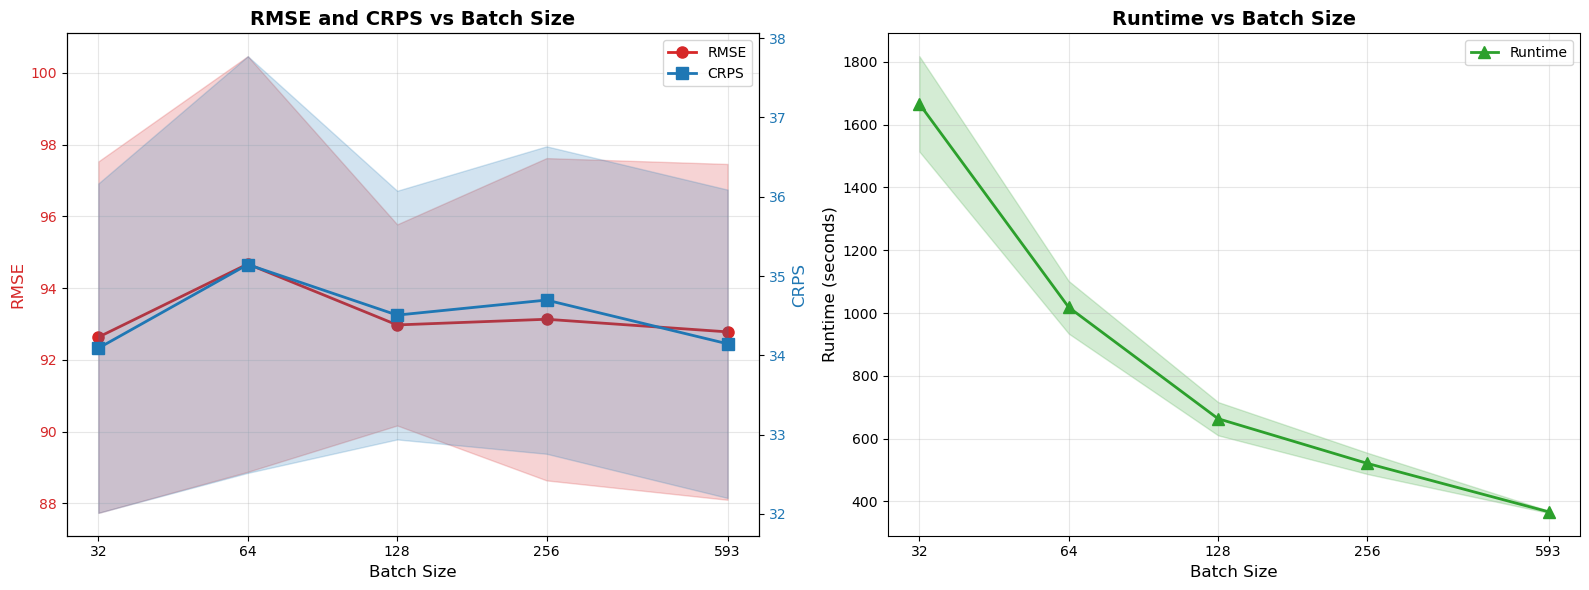


=== 详细统计分析 ===
               rmse                            mean_crps                   \
               mean     std      min       max      mean     std      min   
batch_size                                                                  
32          92.6343  4.8977  84.8877   97.2611   34.0909  2.0769  30.8682   
64          94.6735  5.7922  88.4523  101.0970   35.1460  2.6273  32.4377   
128         92.9750  2.8024  90.2880   96.9956   34.5081  1.5676  33.0616   
256         93.1332  4.4914  87.7931   99.9352   34.6977  1.9383  32.7550   
593         92.7816  4.6796  85.6134   96.8340   34.1461  1.9441  31.0792   

                      run_time                                  
                max       mean       std        min        max  
batch_size                                                      
32          36.5438  1666.0456  151.7439  1553.1014  1836.5217  
64          38.0574  1018.1291   83.7108   953.5735  1112.4551  
128         37.0006   663.4423   52.9593  

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

def process_batch_data(data, additional_data=None):
    """
    处理数据，将其转换为DataFrame格式
    """
    all_results = []
    
    # 处理原始数据
    for seed, results_list in data.items():
        for result in results_list:
            # 处理每个结果字典
            processed_result = {}
            for key, value in result.items():
                if isinstance(value, torch.Tensor):
                    # 将torch.tensor转换为float
                    processed_result[key] = value.cpu().item()
                else:
                    processed_result[key] = value
            
            processed_result['seed'] = seed
            all_results.append(processed_result)
    
    # 处理额外的数据 (batch_size=588)
    if additional_data is not None:
        for seed, values in additional_data.items():
            rmse, mean_crps, run_time = values
            processed_result = {
                'm1': 2,  # 根据原数据推断
                'm2': 20, # 根据原数据推断
                'rmse': rmse.cpu().item() if isinstance(rmse, torch.Tensor) else rmse,
                'mean_crps': mean_crps.cpu().item() if isinstance(mean_crps, torch.Tensor) else mean_crps,
                'run_time': run_time,
                'n': 20,  # 根据原数据推断
                # 'batch_size': 588,  # 新的batch_size
                'batch_size': 593,  # 新的batch_size
                'seed': seed
            }
            all_results.append(processed_result)
    
    df = pd.DataFrame(all_results)
    return df

def create_batch_size_plots(df, save_plots=True):
    """
    创建关于batch_size的折线图
    """
    # 按batch_size分组计算均值和标准差
    grouped = df.groupby('batch_size').agg({
        'rmse': ['mean', 'std'],
        'mean_crps': ['mean', 'std'],
        'run_time': ['mean', 'std']
    }).round(4)
    
    # 重置索引并重命名列
    grouped.columns = ['_'.join(col).strip() for col in grouped.columns]
    grouped = grouped.reset_index()
    
    print("按batch_size分组的统计信息:")
    print(grouped)
    
    # 创建图形
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # === 第一个subplot: RMSE和CRPS的双y轴图 ===
    batch_sizes = grouped['batch_size']
    rmse_mean = grouped['rmse_mean']
    rmse_std = grouped['rmse_std']
    crps_mean = grouped['mean_crps_mean']
    crps_std = grouped['mean_crps_std']
    
    # 左y轴：RMSE
    color1 = 'tab:red'
    ax1.set_xlabel('Batch Size', fontsize=12)
    ax1.set_ylabel('RMSE', color=color1, fontsize=12)
    line1 = ax1.plot(batch_sizes, rmse_mean, color=color1, marker='o', 
                     linewidth=2, markersize=8, label='RMSE')
    ax1.fill_between(batch_sizes, rmse_mean - rmse_std, rmse_mean + rmse_std, 
                     color=color1, alpha=0.2)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, alpha=0.3)
    
    # 右y轴：CRPS
    ax1_twin = ax1.twinx()
    color2 = 'tab:blue'
    ax1_twin.set_ylabel('CRPS', color=color2, fontsize=12)
    line2 = ax1_twin.plot(batch_sizes, crps_mean, color=color2, marker='s', 
                          linewidth=2, markersize=8, label='CRPS')
    ax1_twin.fill_between(batch_sizes, crps_mean - crps_std, crps_mean + crps_std, 
                          color=color2, alpha=0.2)
    ax1_twin.tick_params(axis='y', labelcolor=color2)
    
    # 设置标题和图例
    ax1.set_title('RMSE and CRPS vs Batch Size', fontsize=14, fontweight='bold')
    ax1.set_xscale('log', base=2)  # 使用对数尺度显示batch_size
    
    # 设置x轴刻度，包括新的588
    all_batch_sizes = sorted(batch_sizes.tolist())
    ax1.set_xticks(all_batch_sizes)
    ax1.set_xticklabels([str(int(bs)) for bs in all_batch_sizes])
    
    # 合并图例
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_twin.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    # === 第二个subplot: Runtime ===
    runtime_mean = grouped['run_time_mean']
    runtime_std = grouped['run_time_std']
    
    color3 = 'tab:green'
    ax2.plot(batch_sizes, runtime_mean, color=color3, marker='^', 
             linewidth=2, markersize=8, label='Runtime')
    ax2.fill_between(batch_sizes, runtime_mean - runtime_std, runtime_mean + runtime_std, 
                     color=color3, alpha=0.2)
    
    ax2.set_xlabel('Batch Size', fontsize=12)
    ax2.set_ylabel('Runtime (seconds)', fontsize=12)
    ax2.set_title('Runtime vs Batch Size', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.set_xscale('log', base=2)  # 使用对数尺度显示batch_size
    ax2.set_xticks(all_batch_sizes)
    ax2.set_xticklabels([str(int(bs)) for bs in all_batch_sizes])
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig('batch_size_analysis_updated.png', dpi=300, bbox_inches='tight')
        plt.savefig('batch_size_analysis_updated.pdf', bbox_inches='tight')
        print("图表已保存为 batch_size_analysis_updated.png 和 batch_size_analysis_updated.pdf")
    
    plt.show()
    
    return grouped

def create_detailed_analysis(df):
    """
    创建详细的分析图表
    """
    # 计算统计信息
    stats = df.groupby('batch_size').agg({
        'rmse': ['mean', 'std', 'min', 'max'],
        'mean_crps': ['mean', 'std', 'min', 'max'],
        'run_time': ['mean', 'std', 'min', 'max']
    }).round(4)
    
    print("\n=== 详细统计分析 ===")
    print(stats)
    
    # 找出最佳batch_size
    batch_stats = df.groupby('batch_size').agg({
        'rmse': 'mean',
        'mean_crps': 'mean',
        'run_time': 'mean'
    })
    
    best_rmse_batch = batch_stats['rmse'].idxmin()
    best_crps_batch = batch_stats['mean_crps'].idxmin()
    fastest_batch = batch_stats['run_time'].idxmin()
    
    print(f"\n=== 最佳Batch Size分析 ===")
    print(f"最低RMSE的batch_size: {best_rmse_batch} (RMSE: {batch_stats.loc[best_rmse_batch, 'rmse']:.4f})")
    print(f"最低CRPS的batch_size: {best_crps_batch} (CRPS: {batch_stats.loc[best_crps_batch, 'mean_crps']:.4f})")
    print(f"最快运行的batch_size: {fastest_batch} (Runtime: {batch_stats.loc[fastest_batch, 'run_time']:.1f}s)")
    
    # 显示所有batch_size的性能对比
    print(f"\n=== 所有Batch Size性能对比 ===")
    comparison = batch_stats.round(4)
    comparison = comparison.sort_values('batch_size')
    print(comparison)
    
    return batch_stats

def main():
    """
    主函数
    """
    
    original_data = minibatch_data
    
    additional_data_588 = full_batch_data
    
    # 处理数据，包括新的588数据
    print("处理数据...")
    df = process_batch_data(original_data, additional_data_588)
    
    print(f"数据形状: {df.shape}")
    print(f"batch_size的取值: {sorted(df['batch_size'].unique())}")
    print(f"不同seed数量: {df['seed'].nunique()}")
    
    # 创建折线图
    print("\n创建更新后的batch_size分析图...")
    grouped = create_batch_size_plots(df, save_plots=True)
    
    # 详细分析
    batch_stats = create_detailed_analysis(df)
    
    return df, grouped, batch_stats

if __name__ == "__main__":
    df, grouped, batch_stats = main()

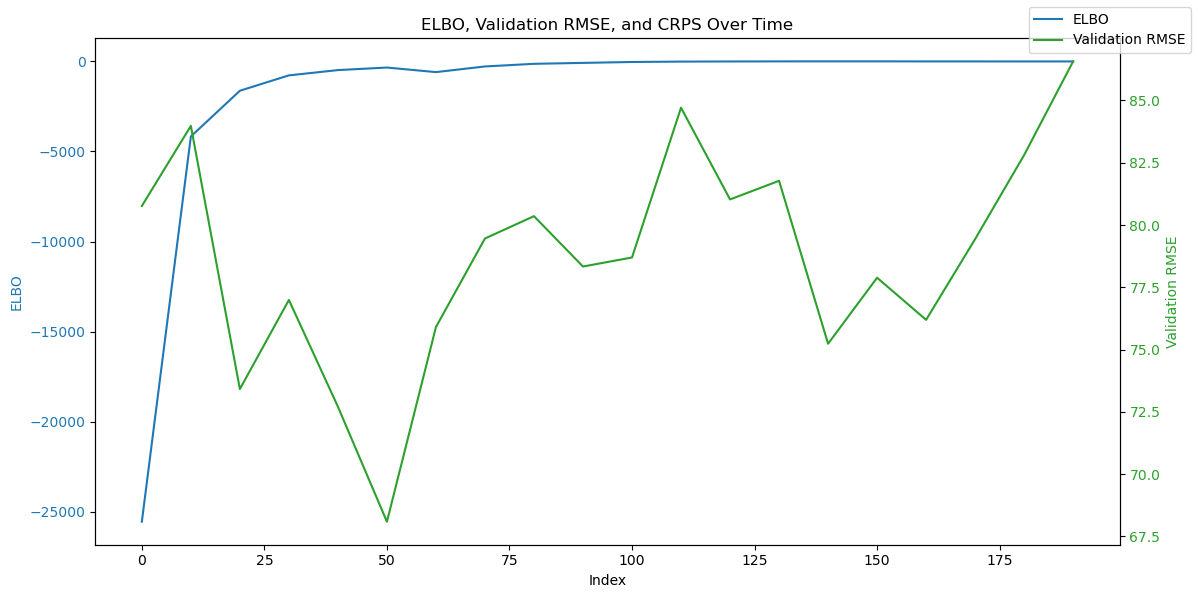

In [69]:
import matplotlib.pyplot as plt

# 原始数据
# data = [
#     (-12645.146434382797, 100.44933319091797, 34.299496), 
#     (-5417.32634850833, 95.66056823730469, 32.988056), 
#     (-3434.297875322604, 100.46058654785156, 35.129143), 
#     (-3363.495287054159, 98.73352813720703, 33.59154), 
#     (-3010.9206832686864, 100.43971252441406, 35.872593), 
#     (-2930.8970959244225, 96.09312438964844, 34.009693), 
#     (-2671.9156402033723, 101.72838592529297, 36.120033), 
#     (-2416.201515549249, 97.78324890136719, 35.47921), 
#     (-2333.012745150129, 105.6688003540039, 36.64742), 
#     (-2072.1757041197257, 104.98168182373047, 38.211143), 
#     (-1972.8669405912835, 97.89445495605469, 34.76983), 
#     (-1584.6257268191534, 95.6343765258789, 33.41784), 
#     (-1520.4135658549715, 93.50419616699219, 33.829132), 
#     (-1301.8255956067667, 88.18934631347656, 32.382717), 
#     (-1244.1559871335824, 92.127197265625, 32.139885), 
#     (-1078.204976377347, 103.29605865478516, 36.567135), 
#     (-891.6686390629083, 101.38188934326172, 36.213787), 
#     (-806.7846543013208, 95.3860855102539, 34.81144), 
#     (-787.0749838967703, 98.51195526123047, 35.0007), 
#     (-608.3430624080128, 101.31253051757812, 35.951866), 
#     (-547.4442936131256, 97.90648651123047, 33.8154), 
#     (-437.941908056594, 98.92021942138672, 35.39146), 
#     (-335.31883697569185, 96.26963806152344, 33.499832), 
#     (-299.3498122150923, 100.12517547607422, 36.44383), 
#     (-234.92579562589702, 98.3154525756836, 35.312607), 
#     (-254.31293652123776, 99.40167236328125, 33.472878), 
#     (-157.98090717182305, 99.34517669677734, 35.877472), 
#     (-169.32689838289986, 96.03701782226562, 34.429375), 
#     (-106.84212450021828, 105.85238647460938, 37.375584), 
#     (-121.02863751391328, 103.97144317626953, 37.108418), 
#     (-73.64061295671652, 95.53995513916016, 34.45893), 
#     (-83.32834373627838, 90.8003158569336, 33.224808), 
#     (-50.34455074729813, 95.10467529296875, 34.180565), 
#     (-41.30584508676146, 102.37649536132812, 36.99698), 
#     (-34.680766806609476, 103.6435317993164, 38.595726), 
#     (-30.241256524021413, 97.545654296875, 35.082066), 
#     (-26.172717492719784, 94.73009490966797, 33.180298), 
#     (-22.592563173200972, 107.99430847167969, 37.74672), 
#     (-21.236363975734815, 95.20365905761719, 34.398014), 
#     (-19.723015314376088, 95.11664581298828, 32.941544), 
#     (-18.11146744016893, 98.56476593017578, 35.17273), 
#     (-16.65671454402149, 104.03719329833984, 37.726067), 
#     (-15.256989900279178, 100.48922729492188, 37.68839), 
#     (-13.961446387956064, 100.86174774169922, 36.195553), 
#     (-14.426882569406098, 101.87959289550781, 35.16848), 
#     (-12.485384896769261, 104.0301513671875, 36.822445), 
#     (-11.6257561757898, 100.54582214355469, 36.560467), 
#     (-43.11180089501791, 104.09486389160156, 37.52355), 
#     (-9.831885519304654, 100.22006225585938, 34.92226), 
#     (-9.03849922836287, 93.29379272460938, 34.31952)
# ]

# data = [(-24055.044574211934, 101.95103454589844, 35.390476), (-3526.089988630493, 100.38320922851562, 36.65569), (-1592.7733724472794, 104.43576049804688, 37.722965), (-715.6735470335772, 107.32730865478516, 38.556885), (-365.40978388913936, 97.39031982421875, 36.12078), (-352.30326374599815, 99.23550415039062, 34.99758), (-578.7583501431668, 98.48106384277344, 36.186127), (-293.5451774251195, 106.2674789428711, 37.513348), (-147.38477870273968, 111.08155822753906, 38.194736), (-73.17310077880738, 93.55618286132812, 34.390614), (-48.93251722138218, 98.2579345703125, 34.4151), (-18.340064764672928, 97.15077209472656, 34.97585), (-6.714618999562139, 104.07766723632812, 36.4746), (-2.73782703959187, 97.05785369873047, 34.67703), (-1.800413868829687, 97.12555694580078, 35.94033), (-1.7728004253914236, 107.82180786132812, 39.882004), (-9.471748469281613, 100.92273712158203, 35.72534), (-4.726308360646824, 99.72639465332031, 34.62988), (-7.2537725782043285, 97.3602294921875, 33.944355), (-8.720855322310548, 104.79788970947266, 37.55172)]

# data = [(-24054.87114600371, 92.62018585205078, 32.407547), (-3526.0588769752285, 92.18955993652344, 33.926247), (-1592.7388331006935, 101.87594604492188, 36.65072), (-715.6576027930496, 94.98677062988281, 35.106133), (-365.401555134934, 96.15310668945312, 36.340687), (-352.2952212501018, 106.84895324707031, 37.74226), (-578.7540780317197, 97.48506164550781, 35.321087), (-293.54725959659436, 100.67803955078125, 35.66059), (-147.38152484322364, 106.29625701904297, 37.741165), (-73.1726567674937, 90.0830078125, 32.979225), (-48.926281462773815, 95.29633331298828, 35.69565), (-18.320957807658207, 97.22156524658203, 35.87702), (-6.71501107128186, 85.65030670166016, 31.523775), (-2.7377066189011647, 90.90409851074219, 33.387074), (-1.800292487986939, 98.76545715332031, 35.852074), (-1.7727837063760563, 94.41167449951172, 33.967106), (-9.74753435808473, 94.13858795166016, 35.29934), (-4.785042423835516, 90.94833374023438, 33.491074), (-7.233920590823219, 98.07073211669922, 34.610844), (-8.741342753500454, 91.05277252197266, 33.918427)]

data = [(-25548.43508846898, 80.76217651367188, 30.188757), (-4170.535501178686, 83.977783203125, 30.497738), (-1633.2226814949456, 73.41127014160156, 28.167488), (-779.7677964405536, 76.98946380615234, 29.030392), (-486.68294503226923, 72.70512390136719, 28.091574), (-345.86878841674064, 68.0855484008789, 26.8295), (-599.074060294075, 75.90147399902344, 28.65108), (-285.47497588415524, 79.45753479003906, 29.603874), (-138.72732021960744, 80.35369873046875, 31.15333), (-87.6155659993057, 78.3315200805664, 29.303173), (-36.544330468050816, 78.694580078125, 30.35494), (-15.844578072146513, 84.70950317382812, 30.947048), (-8.374821866655044, 81.02607727050781, 30.353168), (-3.4055833559570274, 81.77371215820312, 31.397238), (-1.8385411551491564, 75.2322006225586, 27.374065), (-1.8089115604921133, 77.88204193115234, 29.18706), (-5.1502462202771495, 76.190673828125, 29.100338), (-5.111628174890952, 79.43389892578125, 29.681078), (-7.420255340369125, 82.808837890625, 30.38762), (-6.799883135326616, 86.5699462890625, 31.89813)]

# 分离数据
x = list(range(len(data)))
x = [t*10 for t in x]
elbo = [t[0] for t in data]
rmse = [t[1] for t in data]
crps = [t[2] for t in data]

# 主图和第一个 Y 轴（elbo）
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel("Index")
ax1.set_ylabel("ELBO", color='tab:blue')
l1, = ax1.plot(x, elbo, color='tab:blue', label="ELBO")
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 第二个 Y 轴（RMSE）
ax2 = ax1.twinx()
ax2.set_ylabel("Validation RMSE", color='tab:green')
l2, = ax2.plot(x, rmse, color='tab:green', label="Validation RMSE")
ax2.tick_params(axis='y', labelcolor='tab:green')

# 第三个 Y 轴（CRPS）
# ax3 = ax1.twinx()
# ax3.spines['right'].set_position(('outward', 60))  # 创建偏移的第三轴
# ax3.set_ylabel("Validation CRPS", color='tab:red')
# l3, = ax3.plot(x, crps, color='tab:red', label="Validation CRPS")
# ax3.tick_params(axis='y', labelcolor='tab:red')

# 图例
# lines = [l1, l2, l3]
lines = [l1, l2]
labels = [line.get_label() for line in lines]
plt.title("ELBO, Validation RMSE, and CRPS Over Time")
fig.legend(lines, labels, loc='upper right')
plt.tight_layout()
plt.show()


In [70]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_metrics_boxplot(results: dict, output_file: str):
    """
    Plot boxplots for RMSE and CRPS across methods, with mean lines overlaid (excluding outliers).
    """
    def remove_outliers_iqr(values):
        """Remove outliers using IQR method."""
        q1 = np.percentile(values, 25)
        q3 = np.percentile(values, 75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        return [v for v in values if lower <= v <= upper]

    metrics = ['rmse', 'crps']
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    axes = axes.ravel()

    colors = {
        'JGP_RAW':    'blue',
        'JGP_SIR': 'red',
        'DGP':    'green',
        'LMJGP':      'cyan',
        'GPsir':     'purple',
        'GP':        'orange',
        'NNJGP':     'magenta',
        'BNNJGP':    'brown',
    }

    metric_by_method = {}
    for run_res in results.values():
        for method, vals in run_res.items():
            if method == 'JGP_SIR':
                method = 'JGP-SIR'
            if method == 'JGP_RAW':
                method = 'JGP-RAW'
            base = method.split('_')[0]
            if base == 'DJGP':
                base = 'LMJGP'

            raw_rmse, raw_crps = vals[0], vals[1]
            rmse = (raw_rmse.detach().cpu().item()
                    if isinstance(raw_rmse, torch.Tensor)
                    else float(raw_rmse))
            crps = (raw_crps.detach().cpu().item()
                    if isinstance(raw_crps, torch.Tensor)
                    else float(raw_crps))
            metric_by_method.setdefault(base, []).append((rmse, crps))

    labels = sorted(metric_by_method.keys())

    for i, metric in enumerate(metrics):
        ax = axes[i]
        data = [
            [entry[i] for entry in metric_by_method[base]]
            for base in labels
        ]

        # Draw boxplots
        bp = ax.boxplot(
            data,
            tick_labels=labels,
            patch_artist=True,
            showfliers=False
        )

        # Color patches
        for patch, base in zip(bp['boxes'], labels):
            patch.set_facecolor('gray')
            patch.set_edgecolor('black')

        # Compute mean excluding outliers
        means = []
        for values in data:
            filtered = remove_outliers_iqr(values)
            mean_val = np.mean(filtered) if filtered else np.nan
            means.append(mean_val)

        # Overlay mean line
        ax.plot(
            range(1, len(labels) + 1),
            means,
            marker='o',
            color='black',
            linestyle='--',
            label='Mean (no outliers)'
        )

        ax.set_title(f'{metric.upper()} by Method')
        ax.set_ylabel(metric.upper())
        ax.grid(True, axis='y')
        ax.tick_params(axis='x', rotation=45)
        ax.legend()

    plt.tight_layout()
    plt.savefig(output_file, bbox_inches='tight', dpi=300)
    plt.close()
    print(f"Saved boxplot to {output_file}")


In [83]:
import pickle

# 打开文件（注意 rb 模式）
# C:\Users\yxu59\files\spring2025\park\code\DeepMahalaJumpGP\exp_data\jgp_alone\Phatom expansion methods_4caseno_1000N_20D_3K_2noise_std
with open('exp_data\\jgp_alone\\Phatom expansion methods_4caseno_1000N_20D_3K_2noise_std\\results_D=20_Q=2_M=25_K=3_N=1000_noise_var=4_method=random projection.pkl', 'rb') as f:
    phantom_rp_data = pickle.load(f)

In [84]:
plot_metrics_boxplot(phantom_rp_data, 'exp_data\\jgp_alone\\Phatom expansion methods_4caseno_1000N_20D_3K_2noise_std\\results_D=20_Q=2_M=25_K=3_N=1000_noise_var=4_method=random projection.png')

Saved boxplot to exp_data\jgp_alone\Phatom expansion methods_4caseno_1000N_20D_3K_2noise_std\results_D=20_Q=2_M=25_K=3_N=1000_noise_var=4_method=random projection.png


In [75]:
import pickle

# 打开文件（注意 rb 模式）
with open("exp_data\\erosion_new_dataset\\erosion_K_Appliances\\Appliances_K_erosion_res.pkl", 'rb') as f:
    Appliance_K_data = pickle.load(f)

In [76]:
Appliance_K_data

{0: [{'m1': 4,
   'm2': 40,
   'rmse': tensor(91.3962, device='cuda:0'),
   'mean_crps': tensor(33.6890, device='cuda:0'),
   'run_time': 251.97782683372498,
   'n': 35,
   'batch_size': 64,
   'K': 2},
  {'m1': 4,
   'm2': 40,
   'rmse': tensor(88.7213, device='cuda:0'),
   'mean_crps': tensor(32.9140, device='cuda:0'),
   'run_time': 351.7888252735138,
   'n': 35,
   'batch_size': 64,
   'K': 3},
  {'m1': 4,
   'm2': 40,
   'rmse': tensor(89.0318, device='cuda:0'),
   'mean_crps': tensor(32.7306, device='cuda:0'),
   'run_time': 575.0755109786987,
   'n': 35,
   'batch_size': 64,
   'K': 5},
  {'m1': 4,
   'm2': 40,
   'rmse': tensor(90.5140, device='cuda:0'),
   'mean_crps': tensor(32.6834, device='cuda:0'),
   'run_time': 843.7160120010376,
   'n': 35,
   'batch_size': 64,
   'K': 7}],
 1: [{'m1': 4,
   'm2': 40,
   'rmse': tensor(106.6283, device='cuda:0'),
   'mean_crps': tensor(41.5298, device='cuda:0'),
   'run_time': 258.90507793426514,
   'n': 35,
   'batch_size': 64,
   'K':

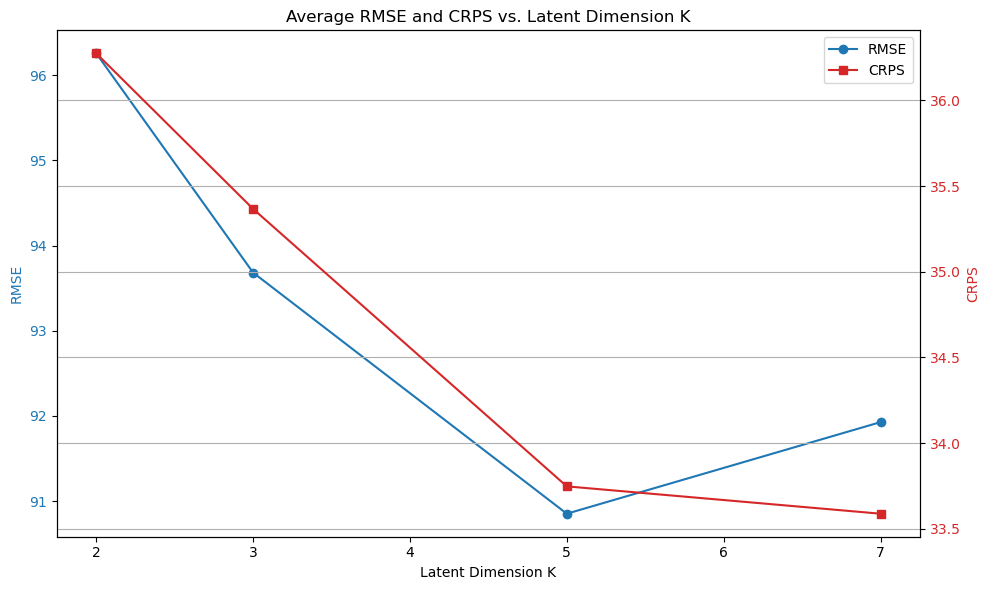

In [78]:
import matplotlib.pyplot as plt

# Extracted and simplified numerical values from the user's data
data = Appliance_K_data

# Aggregate by K
k_vals = sorted({entry['K'] for entries in data.values() for entry in entries})
rmse_by_k = {k: [] for k in k_vals}
crps_by_k = {k: [] for k in k_vals}

for run_entries in data.values():
    for entry in run_entries:
        k = entry['K']
        rmse_by_k[k].append(entry['rmse'].detach().cpu().item())
        crps_by_k[k].append(entry['mean_crps'].detach().cpu().item())

# Average for plotting
avg_rmse = [sum(rmse_by_k[k]) / len(rmse_by_k[k]) for k in k_vals]
avg_crps = [sum(crps_by_k[k]) / len(crps_by_k[k]) for k in k_vals]

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

color_rmse = 'tab:blue'
color_crps = 'tab:red'

ax1.set_xlabel('Latent Dimension K')
ax1.set_ylabel('RMSE', color=color_rmse)
ln1 = ax1.plot(k_vals, avg_rmse, marker='o', color=color_rmse, label='RMSE')
ax1.tick_params(axis='y', labelcolor=color_rmse)

ax2 = ax1.twinx()
ax2.set_ylabel('CRPS', color=color_crps)
ln2 = ax2.plot(k_vals, avg_crps, marker='s', color=color_crps, label='CRPS')
ax2.tick_params(axis='y', labelcolor=color_crps)

lns = ln1 + ln2
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='upper right')

plt.title('Average RMSE and CRPS vs. Latent Dimension K')
plt.grid(True)
plt.tight_layout()
plt.show()


In [81]:
import matplotlib.pyplot as plt
import torch

def plot_k_vs_metrics_with_boxplot(full_results: dict, output_prefix: str):
    """
    画出不同K对应的RMSE和CRPS的折线图 + boxplot，每个指标单独成图。
    """
    # 收集所有K值
    k_vals = sorted({entry['K'] for entries in full_results.values() for entry in entries})

    # 构建K到metric值的映射
    rmse_by_k = {k: [] for k in k_vals}
    crps_by_k = {k: [] for k in k_vals}

    for run_entries in full_results.values():
        for entry in run_entries:
            k = entry['K']
            rmse = entry['rmse'].item() if isinstance(entry['rmse'], torch.Tensor) else float(entry['rmse'])
            crps = entry['mean_crps'].item() if isinstance(entry['mean_crps'], torch.Tensor) else float(entry['mean_crps'])
            rmse_by_k[k].append(rmse)
            crps_by_k[k].append(crps)

    # 准备绘图数据
    def plot_metric(metric_by_k, ylabel, filename, color, marker):
        k_vals = sorted(metric_by_k.keys())
        data = [metric_by_k[k] for k in k_vals]
        means = [sum(vals) / len(vals) for vals in data]

        fig, ax = plt.subplots(figsize=(10, 6))

        # boxplot
        bp = ax.boxplot(
            data,
            positions=k_vals,
            patch_artist=True,
            showfliers=False
        )
        for patch in bp['boxes']:
            patch.set_facecolor('gray')
            patch.set_edgecolor('black')

        # 折线图（平均值）
        ax.plot(k_vals, means, marker=marker, color='black', linestyle='--', label='Mean')

        ax.set_xlabel('Latent Dimension Q')
        ax.set_ylabel(ylabel)
        ax.set_title(f'{ylabel} vs. Latent Dimension Q')
        ax.grid(True, axis='y')
        ax.legend()

        plt.tight_layout()
        plt.savefig(f"{output_prefix}_{ylabel.lower()}.png", bbox_inches='tight', dpi=300)
        plt.close()
        print(f"Saved {ylabel} plot to {output_prefix}_{ylabel.lower()}.png")

    # 分别画 RMSE 和 CRPS
    plot_metric(rmse_by_k, 'RMSE', output_prefix, 'tab:blue', 'o')
    plot_metric(crps_by_k, 'CRPS', output_prefix, 'tab:red', 's')

# 使用用户之前上传的 full_results 数据绘图
plot_k_vs_metrics_with_boxplot(full_results=Appliance_K_data, output_prefix="exp_data\\erosion_new_dataset\\erosion_K_Appliances\\erosion_K_Appliances")


Saved RMSE plot to exp_data\erosion_new_dataset\erosion_K_Appliances\erosion_K_Appliances_rmse.png
Saved CRPS plot to exp_data\erosion_new_dataset\erosion_K_Appliances\erosion_K_Appliances_crps.png


In [100]:
import pickle

# 打开文件（注意 rb 模式）
with open("exp_data\\erosion_new_dataset\\erosion_K_Parkinsons\\Parkinsons_K_erosion_res.pkl", 'rb') as f:
    Parkinsons_K_data = pickle.load(f)

plot_k_vs_metrics_with_boxplot(full_results=Parkinsons_K_data, output_prefix="exp_data\\erosion_new_dataset\\erosion_K_Parkinsons\\erosion_K_Parkinsons")


Saved RMSE plot to exp_data\erosion_new_dataset\erosion_K_Parkinsons\erosion_K_Parkinsons_rmse.png
Saved CRPS plot to exp_data\erosion_new_dataset\erosion_K_Parkinsons\erosion_K_Parkinsons_crps.png
